# 🧠 Classificação e Segmentação de Imagens de Ultrassom da Mama
Usando VGG-16 (classificação) e U-Net (segmentação) com o dataset do Kaggle.

In [3]:
%pip install tensorflow opencv-python scikit-learn matplotlib kaggle

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 📥 Download do Dataset via Kaggle API

In [5]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0




  0%|          | 0.00/195M [00:00<?, ?B/s]
 35%|███▌      | 69.0M/195M [00:00<00:00, 717MB/s]
 71%|███████   | 138M/195M [00:00<00:00, 359MB/s] 
 98%|█████████▊| 192M/195M [00:00<00:00, 419MB/s]
100%|██████████| 195M/195M [00:00<00:00, 421MB/s]


In [6]:
import os, zipfile

os.environ['KAGGLE_CONFIG_DIR'] = '.'

with zipfile.ZipFile("breast-ultrasound-images-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("breast_ultrasound_dataset")

print("✅ Dataset baixado e extraído com sucesso!")


✅ Dataset baixado e extraído com sucesso!


## 📁 Importação de Bibliotecas

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow as tf

## 🗂️ Carregamento e Pré-processamento para Classificação

In [9]:
base_path = 'breast_ultrasound_dataset/Dataset_BUSI_with_GT/'
classes = ['benign', 'malignant', 'normal']
img_size = 224

X = []
y = []

for idx, label in enumerate(classes):
    folder = os.path.join(base_path, label)
    for filename in os.listdir(folder):
        if 'mask' not in filename:
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(idx)

X = np.array(X) / 255.0
y = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 🧠 Modelo VGG-16 para Classificação

In [10]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in vgg.layers:
    layer.trainable = False

x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model_class = Model(inputs=vgg.input, outputs=predictions)
model_class.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_class.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 📊 Treinamento do Modelo de Classificação

In [11]:
model_class.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=16)

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.5017 - loss: 1.0124 - val_accuracy: 0.5641 - val_loss: 0.9071
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.5806 - loss: 0.9063 - val_accuracy: 0.6538 - val_loss: 0.8620
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.6447 - loss: 0.8377 - val_accuracy: 0.6538 - val_loss: 0.8168
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.6098 - loss: 0.8412 - val_accuracy: 0.6667 - val_loss: 0.7900
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6576 - loss: 0.7659 - val_accuracy: 0.6731 - val_loss: 0.7691


## 🖼️ Função para Carregar Imagens e Máscaras (Segmentação)

In [12]:
def load_images_and_masks(class_folder):
    img_list = []
    mask_list = []
    folder = os.path.join(base_path, class_folder)
    for fname in os.listdir(folder):
        if 'mask' not in fname:
            img_path = os.path.join(folder, fname)
            mask_path = os.path.join(folder, fname.split('.')[0] + '_mask.png')
            if not os.path.exists(mask_path): continue
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128))
            img = img / 255.0
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (128, 128))
            mask = np.expand_dims(mask, axis=-1) / 255.0
            img_list.append(img)
            mask_list.append(mask)
    return img_list, mask_list

## 📥 Carregamento dos Dados de Segmentação

In [13]:
X_seg, y_seg = [], []
for c in ['benign', 'malignant']:
    imgs, masks = load_images_and_masks(c)
    X_seg += imgs
    y_seg += masks

X_seg = np.array(X_seg)
y_seg = np.array(y_seg)

X_train_seg, X_val_seg, y_train_seg, y_val_seg = train_test_split(X_seg, y_seg, test_size=0.2, random_state=42)

## 🧬 Modelo U-Net para Segmentação

In [14]:
def unet_model(input_size=(128,128,3)):
    inputs = Input(input_size)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

model_seg = unet_model()
model_seg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_seg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_8[0][0]  

 Total params: 118,273 (462.00 KB)

 Trainable params: 118,273 (462.00 KB)

 Non-trainable params: 0 (0.00 B)

## 🧪 Treinamento do Modelo de Segmentação

In [15]:
model_seg.fit(X_train_seg, y_train_seg, validation_data=(X_val_seg, y_val_seg), epochs=10, batch_size=8)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.8649 - loss: 0.4199 - val_accuracy: 0.9070 - val_loss: 0.2847
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.9067 - loss: 0.2816 - val_accuracy: 0.9070 - val_loss: 0.2630
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.9125 - loss: 0.2597 - val_accuracy: 0.9070 - val_loss: 0.2583
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 0.9079 - loss: 0.2589 - val_accuracy: 0.9070 - val_loss: 0.2598
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.9085 - loss: 0.2543 - val_accuracy: 0.9070 - val_loss: 0.2424
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.9078 - loss: 0.2432 - val_accuracy: 0.9082 - val_loss: 0.2446
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.9053 - loss: 0.2529 - val_accuracy: 0.9146 - val_loss: 0.2331
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.9147 - loss: 0.2279 - val_accu

## 🔍 Visualização de Resultados de Segmentação

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


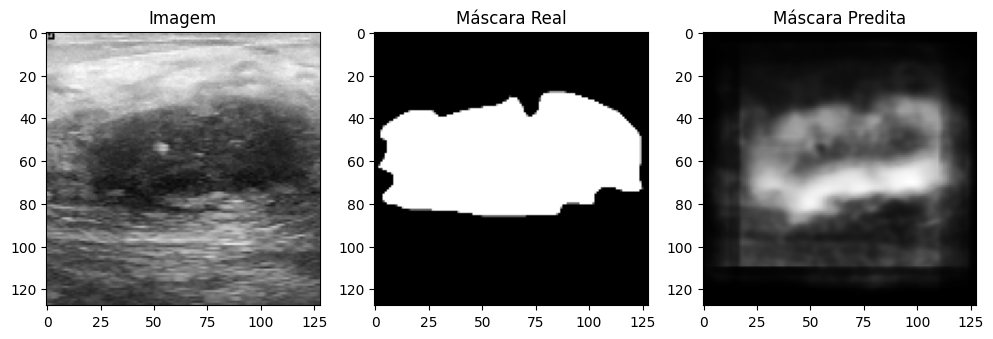

In [18]:
def show_results(model, X, y, index=0):
    pred = model.predict(np.expand_dims(X[index], axis=0))[0]
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(X[index])
    axs[0].set_title("Imagem")
    axs[1].imshow(y[index].squeeze(), cmap='gray')
    axs[1].set_title("Máscara Real")
    axs[2].imshow(pred.squeeze(), cmap='gray')
    axs[2].set_title("Máscara Predita")
    plt.show()

show_results(model_seg, X_val_seg, y_val_seg, index=5)